In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy
import numpy as np

from utils import generate_data
from data import EncoderDataset
from TeacherModel import DeepSupervisionNet
from model import LearnerModel, WaypointDecoder
from loss import KnowledgeDistillationLoss, WaypointMSE

TEXTURE_PATH = "./textures/texture.jpg" # texture of the line drawn in simulation
REAL_IMAGE_PATH = "./real_images/" # real images to augment

TRAIN_DATA_PATH = "./raw_data/train/"
VAL_DATA_PATH = "./raw_data/val/"
FINETUNE_DATA_PATH = "./raw_data/finetune/"
TEST_DATA_PATH = "./raw_data/test/"

TRAIN_DATASET_SIZE = 512
VAL_DATASET_SIZE = 128
FINETUNE_DATASET_SIZE = 256
TEST_DATASET_SIZE = 64

In [5]:
# Make sure the directories exist
directories = [TRAIN_DATA_PATH, VAL_DATA_PATH, FINETUNE_DATA_PATH, TEST_DATA_PATH]

for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)
    image_path = os.path.join(path, 'images')
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    mask_path = os.path.join(path, 'masks')
    if not os.path.exists(mask_path):
        os.makedirs(mask_path)
    waypoint_path = os.path.join(path, 'labels')
    if not os.path.exists(waypoint_path):
        os.makedirs(waypoint_path)

In [8]:
### GENERATE DATA ### (skip if data is already generated)

# generate train dataset
generate_data(line_path=TRAIN_DATA_PATH,
              real_path=REAL_IMAGE_PATH,
              texture_path=TEXTURE_PATH,
              line_dataset_size=TRAIN_DATASET_SIZE)

# generate val dataset
generate_data(line_path=VAL_DATA_PATH,
              real_path=REAL_IMAGE_PATH,
              texture_path=TEXTURE_PATH,
              line_dataset_size=VAL_DATASET_SIZE)

# generate finetune dataset
generate_data(line_path=FINETUNE_DATA_PATH,
              real_path=REAL_IMAGE_PATH,
              texture_path=TEXTURE_PATH,
              line_dataset_size=FINETUNE_DATASET_SIZE)

# generate test dataset
generate_data(line_path=TEST_DATA_PATH,
              real_path=REAL_IMAGE_PATH,
              texture_path=TEXTURE_PATH,
              line_dataset_size=TEST_DATASET_SIZE)

In [11]:
### SET DEVICE ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
### DECLARE DATASETS AND DATALOADERS ###
batch_size = 32

train_dataset = EncoderDataset(TRAIN_DATA_PATH, dataset_size=TRAIN_DATASET_SIZE)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EncoderDataset(VAL_DATA_PATH, dataset_size=VAL_DATASET_SIZE)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

finetune_dataset = EncoderDataset(FINETUNE_DATA_PATH, dataset_size=FINETUNE_DATASET_SIZE)
finetune_loader = DataLoader(finetune_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EncoderDataset(TEST_DATA_PATH, dataset_size=TEST_DATASET_SIZE)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
### TEACHER MODEL TRAINING ###

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Initialize DeepSupervisionNet
teacher_model = DeepSupervisionNet(batch_norm=True).to(device)
teacher_model.train()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(teacher_model.parameters(), lr=0.003)

# Directory to save the model
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# Check if a saved model exists and load it
if os.path.exists(os.path.join(save_dir, 'DeepSupervisionNet.pth')):
    teacher_model.load_state_dict(torch.load(os.path.join(save_dir, 'DeepSupervisionNet.pth')))
    print("Loaded saved model.")

# Training loop
epochs = 20
checkpoint_epochs = [3, 6, 9, 12, 15, 18]  # Epochs at which to save checkpoints

for epoch in range(epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        labels = batch['mask'].float().to(device) / 255.0  # Normalize, convert to float, and move to device

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass with intermediate outputs
        intermediate_outputs = teacher_model(inputs, intermediate_outputs=True)

        # Compute loss for each intermediate output and the final output
        losses = [criterion(output, labels) for output in intermediate_outputs[:5]]

        # Sum up the losses
        loss = sum(losses)

        # Backward propagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / (i + 1):.4f}")

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Save checkpoint if the epoch is in checkpoint_epochs
    if (epoch + 1) in checkpoint_epochs:
        checkpoint_name = f'DeepSupervisionNet_epoch_{epoch + 1}.pth'
        torch.save(teacher_model.state_dict(), os.path.join(save_dir, checkpoint_name))
        print(f"Saved checkpoint at epoch {epoch + 1}")

# Save the final model
final_model_name = 'DeepSupervisionNet_final.pth'
torch.save(teacher_model.state_dict(), os.path.join(save_dir, final_model_name))
print(f"Saved final model")

print("Training completed!")

Epoch [1/20], Step [10/16], Loss: 2.1210
Epoch [1/20], Loss: 1.7373
Epoch [2/20], Step [10/16], Loss: 0.8998
Epoch [2/20], Loss: 0.8352
Epoch [3/20], Step [10/16], Loss: 0.6494
Epoch [3/20], Loss: 0.6272
Saved checkpoint at epoch 3
Epoch [4/20], Step [10/16], Loss: 0.8809
Epoch [4/20], Loss: 0.8124
Epoch [5/20], Step [10/16], Loss: 0.6112
Epoch [5/20], Loss: 0.5960
Epoch [6/20], Step [10/16], Loss: 0.5141
Epoch [6/20], Loss: 0.5042
Saved checkpoint at epoch 6
Epoch [7/20], Step [10/16], Loss: 0.4712
Epoch [7/20], Loss: 0.4608
Epoch [8/20], Step [10/16], Loss: 0.5284
Epoch [8/20], Loss: 0.5445
Epoch [9/20], Step [10/16], Loss: 0.4848
Epoch [9/20], Loss: 0.4732
Saved checkpoint at epoch 9
Epoch [10/20], Step [10/16], Loss: 0.4267
Epoch [10/20], Loss: 0.4383
Epoch [11/20], Step [10/16], Loss: 0.3687
Epoch [11/20], Loss: 0.3644
Epoch [12/20], Step [10/16], Loss: 0.3801
Epoch [12/20], Loss: 0.3734
Saved checkpoint at epoch 12
Epoch [13/20], Step [10/16], Loss: 0.3232
Epoch [13/20], Loss: 0.

In [15]:
### LOAD TRAINED TEACHER MODEL CHECKPOINT ###
teacher_model = DeepSupervisionNet(batch_norm=True).to(device)
teacher_model.load_state_dict(torch.load('./saved_models/DeepSupervisionNet_final.pth', map_location=device))

<All keys matched successfully>

In [29]:
### KNOWLEDGE DISTILATION TRAINING ###

# Set teacher model to eval mode
teacher_model.eval()

# Initialize DeepSupervisionNet
learner_model = LearnerModel().to(device)
learner_model.train()

# Define loss function and optimizer
criterion = KnowledgeDistillationLoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(learner_model.parameters(), lr=0.003)

# Directory to save the model
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# Kknowledge Distilation Training Loop
epochs = 20
checkpoint_epochs = [3, 6, 9, 12, 15, 18]  # Epochs at which to save checkpoints

for epoch in range(epochs):
    running_loss = 0.0
    for i , batch in enumerate(train_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        labels = batch['mask'].float().to(device) / 255.0  # Normalize, convert to float, and move to device

        optimizer.zero_grad()

        with torch.no_grad():
            intermediate_outputs = teacher_model(inputs, intermediate_outputs=True)
            teacher_outputs = intermediate_outputs[5:] # modified model to output intermediate layers for training the student model. only need 'x1', 'x2' and 'x4'

        teacher_outputs.pop(2) # discard the third output

        learner_outputs, _ = learner_model(inputs, intermediate_outputs=True)

        # Compute the loss over each of the intermediate outputs from the teacher and student models
        losses = []
        for learner_output, teacher_output in zip(learner_outputs, teacher_outputs):
            # print(f'Shape of learner output: {learner_output.shape}')
            # print(f'Shape of teacher output: {teacher_output.shape}')
            losses.append(criterion(learner_output, teacher_output))

        # losses = [criterion(learner_output, teacher_output) for learner_output, teacher_output in zip(learner_outputs, teacher_outputs)]

        # Sum up the losses
        loss = sum(losses)

        # Backward propagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / (i + 1):.4f}")

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Save checkpoint if the epoch is in checkpoint_epochs
    if (epoch + 1) in checkpoint_epochs:
        checkpoint_name = f'LearnerModel_epoch_{epoch + 1}.pth'
        torch.save(learner_model.state_dict(), os.path.join(save_dir, checkpoint_name))
        print(f"Saved checkpoint at epoch {epoch + 1}")

# Save the final model
final_model_name = 'LearnerModel_final.pth'
torch.save(learner_model.state_dict(), os.path.join(save_dir, final_model_name))
print(f"Saved final model")

print("Training completed!")

Epoch [1/20], Step [10/16], Loss: 2263163.5469
Epoch [1/20], Loss: 1700536.1875
Epoch [2/20], Step [10/16], Loss: 364690.0547
Epoch [2/20], Loss: 328378.2500
Epoch [3/20], Step [10/16], Loss: 234467.5453
Epoch [3/20], Loss: 212658.4844
Saved checkpoint at epoch 3
Epoch [4/20], Step [10/16], Loss: 152704.3680
Epoch [4/20], Loss: 146473.6406
Epoch [5/20], Step [10/16], Loss: 121983.3398
Epoch [5/20], Loss: 116996.8872
Epoch [6/20], Step [10/16], Loss: 102874.9750
Epoch [6/20], Loss: 98942.0854
Saved checkpoint at epoch 6
Epoch [7/20], Step [10/16], Loss: 90067.7695
Epoch [7/20], Loss: 83704.4241
Epoch [8/20], Step [10/16], Loss: 72839.6719
Epoch [8/20], Loss: 73837.0403
Epoch [9/20], Step [10/16], Loss: 75965.0285
Epoch [9/20], Loss: 79938.5479
Saved checkpoint at epoch 9
Epoch [10/20], Step [10/16], Loss: 77515.7992
Epoch [10/20], Loss: 81572.8052
Epoch [11/20], Step [10/16], Loss: 102647.3914
Epoch [11/20], Loss: 88983.5728
Epoch [12/20], Step [10/16], Loss: 60371.5367
Epoch [12/20], L

In [ ]:
### LOAD TRAINED STUDENT MODEL CHECKPOINT ###
prune_learner_model = LearnerModel().to(device)
prune_learner_model.load_state_dict(torch.load('./saved_models/LearnerModel_final.pth', map_location=device))

In [ ]:
### STUDENT MODEL PRUNING AND FINE-TUNE TRAINING ###

# Set teacher model to eval mode
teacher_model.eval()

# Define loss function and optimizer
criterion = KnowledgeDistillationLoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(prune_learner_model.parameters(), lr=0.001)

# Directory to save the model
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

epochs = 10 # change epochs here

for epoch in range(epochs):
    running_loss = 0.0
    feat_across_batches = []
    prune_learner_model.eval()
    for batch in val_loader:
        prune_learner_model.to(device)
        inputs = batch['image'].float().to(device)
        with torch.no_grad():
            _, features = prune_learner_model(inputs, intermediate_outputs=True)

        if feat_across_batches == []:
            feat_across_batches = features
        else:
            for i in range(len(features)):
                batch_concat = feat_across_batches[i]
                feat_across_batches[i] = torch.cat((batch_concat, features[i]), 0)

    for i, layer_features in enumerate(feat_across_batches):
        this_layer = []
        num_channels = layer_features.shape[1]
        for j in range(num_channels):
            channel_features = layer_features[:, j, :, :]
            zeroes = torch.sum(channel_features == 0).item()
            num_elements = channel_features.numel()
            channel_apz = zeroes / num_elements
            this_layer.append(channel_apz)

        # prune layer
        layer_mean = np.array(this_layer).mean()
        layer_std = np.array(this_layer).std() * 1.2

        channel_indexes = []
        for k in range(len(this_layer)):
            if (this_layer[k] < (layer_mean - layer_std)) or (this_layer[k] > (layer_mean + layer_std)):
                channel_indexes.append(k)

        model_layers, next_layers = prune_learner_model.get_prunable_layers()
        model_layer = copy.deepcopy(model_layers[i])
        next_layer = copy.deepcopy(next_layers[i])

        for idx in channel_indexes[::-1]:
            model_layer.weight = nn.Parameter(torch.cat([model_layer.weight[:idx, :, :, :],
                                           model_layer.weight[idx+1:, :, :, :]], dim=0))
            model_layer.bias = nn.Parameter(torch.cat([model_layer.bias[:idx], model_layer.bias[idx+1:]], dim=0))
            next_layer.weight = nn.Parameter(torch.cat([next_layer.weight[:, :idx, :, :],
                                           next_layer.weight[:, idx+1:, :, :]], dim=1))

        prune_learner_model.set_pruned_layers(i, model_layer, next_layer, model_layer.weight.shape[0])

    # post-prune fine-tuning
    prune_learner_model.to(device)
    prune_learner_model.train()
    for i , batch in enumerate(finetune_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        labels = batch['mask'].float().to(device) / 255.0  # Normalize, convert to float, and move to device

        optimizer.zero_grad()

        with torch.no_grad():
            intermediate_outputs = teacher_model(inputs, intermediate_outputs=True)
            teacher_outputs = intermediate_outputs[5:] # modified model to output intermediate layers for training the student model. only need 'x1', 'x2' and 'x4'

        teacher_outputs.pop(2) # discard the third output
        learner_outputs, _ = prune_learner_model(inputs, intermediate_outputs=True)

        # Compute the loss over each of the intermediate outputs from the teacher and student models
        losses = []
        for learner_output, teacher_output in zip(learner_outputs, teacher_outputs):
            losses.append(criterion(learner_output, teacher_output))

        loss = sum(losses)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Save checkpoint if the epoch is in checkpoint_epochs
    if (epoch + 1) in checkpoint_epochs:
        checkpoint_name = f'LearnerModelPruned_epoch_{epoch + 1}.pth'
        torch.save(prune_learner_model.state_dict(), os.path.join(save_dir, checkpoint_name))
        print(f"Saved checkpoint at epoch {epoch + 1}")

# Save the final model
final_model_name = 'LearnerModelPruned_final.pth'
torch.save(prune_learner_model.state_dict(), os.path.join(save_dir, final_model_name))
print(f"Saved final model")

print("Training completed!")

In [32]:
# Special code to save pruned model
res1_conv1 = prune_learner_model.resblock1.conv1.bias.shape[0]
res1_conv2 = prune_learner_model.resblock1.conv2.bias.shape[0]
res2_conv1 = prune_learner_model.resblock2.conv1.bias.shape[0]
res2_conv2 = prune_learner_model.resblock2.conv2.bias.shape[0]
pruned_channels = [res1_conv1, res1_conv2, res2_conv1, res2_conv2]

with open('./saved_models/channel_list.txt', 'w') as f:
    for item in pruned_channels:
        f.write(f"{item}\n")

In [14]:
# Special code to load pruned model
channel_list = []
with open('./saved_models/channel_list.txt', 'r') as f:
    for line in f:
        channel_list.append(int(line.strip()))

final_encoder_model = LearnerModel(channel_list).to(device)
final_encoder_model.load_state_dict(torch.load('./saved_models/LearnerModelPruned_final.pth', map_location=device))

<All keys matched successfully>

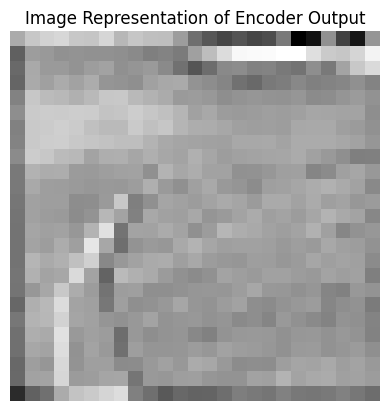

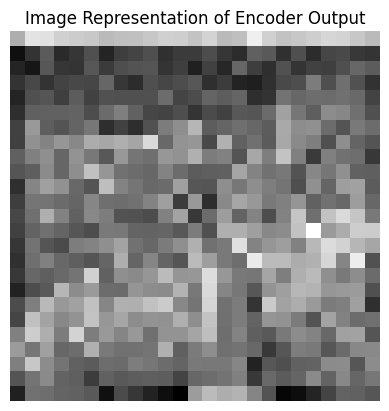

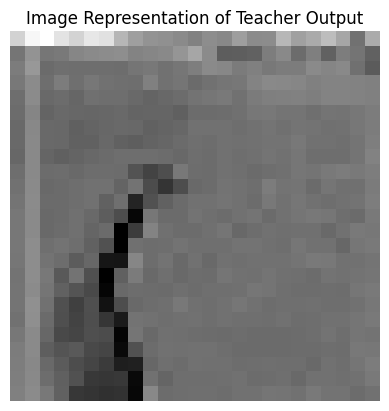

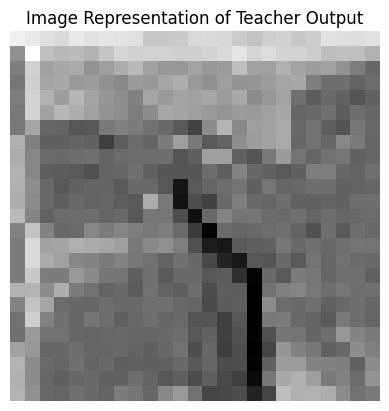

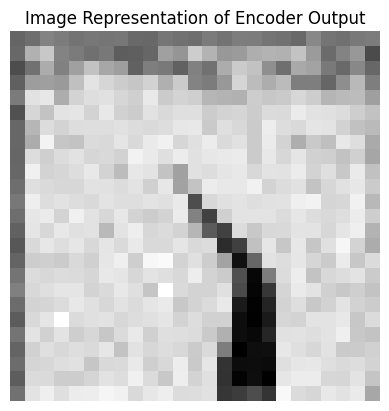

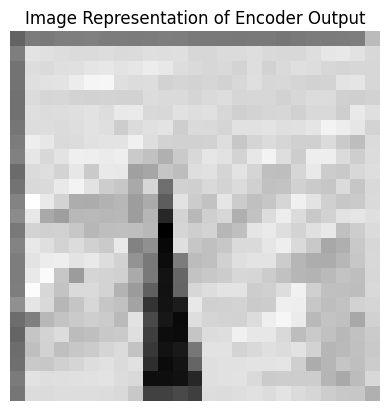

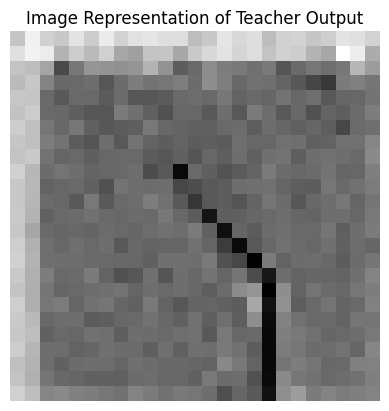

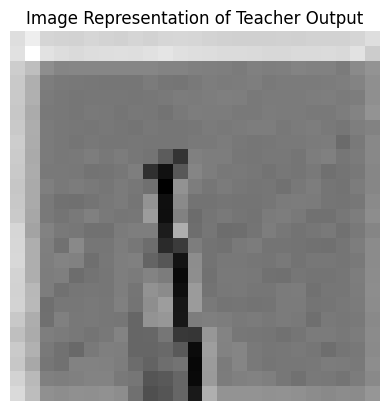

In [33]:
### PLOT OUTPUTS OF ENCODER MODEL FOR VISUALISATION###
import matplotlib.pyplot as plt

with torch.no_grad():  # Disable gradient calculation for inference
    for i, batch in enumerate(test_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        model_outputs = final_encoder_model(inputs)
        teacher_outputs = teacher_model(inputs, intermediate_outputs=True)
        teacher_outputs = teacher_outputs[8]

        for out in model_outputs[:2]:
            out = out.cpu().numpy()
            img = np.mean(out, axis=0)
            img = (img - img.min()) / (img.max() - img.min())

            plt.figure()
            plt.imshow(img, cmap='gray')
            plt.axis('off')  # Hide axis
            plt.title('Image Representation of Encoder Output')
            plt.show()

        for out in teacher_outputs[:2]:
            out = out.cpu().numpy()
            img = np.mean(out, axis=0)
            img = (img - img.min()) / (img.max() - img.min())

            plt.figure()
            plt.imshow(img, cmap='gray')
            plt.axis('off')  # Hide axis
            plt.title('Image Representation of Teacher Output')
            plt.show()

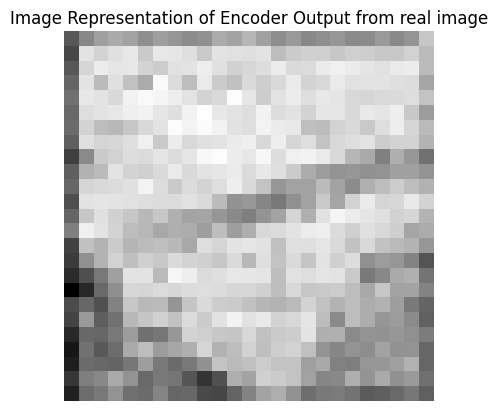

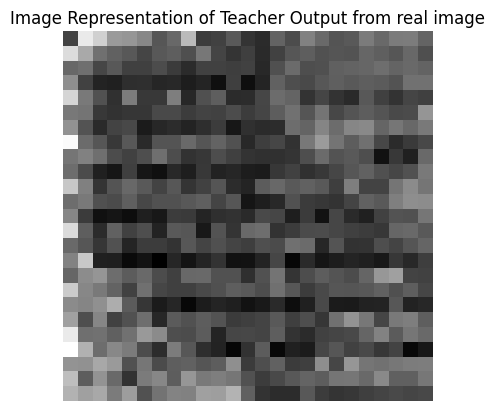

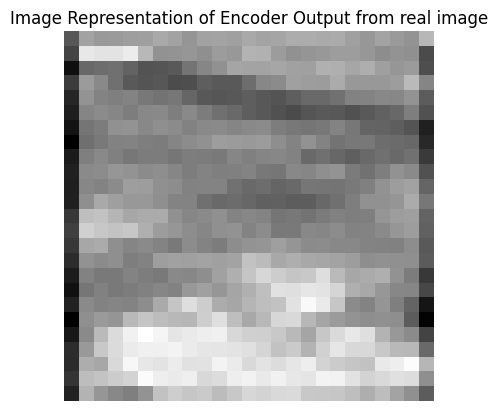

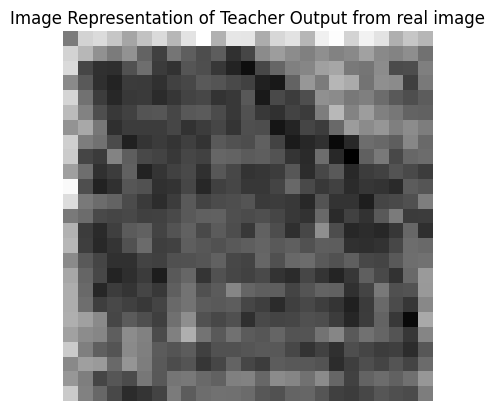

In [50]:
# for testing with real-world examples
from PIL import Image

image1 = Image.open('temp/real_img_1.jpg')
image1 = np.array(image1.resize((200,200)), dtype=np.float32).reshape((3,200,200))
image2 = Image.open('temp/real_img_2.jpg')
image2 = np.array(image2.resize((200,200)), dtype=np.float32).reshape((3,200,200))
real_inputs = np.concatenate((image1[np.newaxis, ...], image2[np.newaxis, ...]), axis=0)
real_inputs = torch.tensor(real_inputs).to(device)
with torch.no_grad():
    model_outputs = final_encoder_model(real_inputs)
    teacher_outputs = teacher_model(real_inputs, intermediate_outputs=True)
    teacher_outputs = teacher_outputs[8]

for out in zip(model_outputs, teacher_outputs):
    out1 = out[0].cpu().numpy()
    img1 = np.mean(out1, axis=0)
    img1 = (img1 - img1.min()) / (img1.max() - img1.min())

    plt.figure()
    plt.imshow(img1, cmap='gray')
    plt.axis('off')  # Hide axis
    plt.title('Image Representation of Encoder Output from real image')

    out2 = out[1].cpu().numpy()
    img2 = np.mean(out2, axis=0)
    img2 = (img2 - img2.min()) / (img2.max() - img2.min())

    plt.figure()
    plt.imshow(img2, cmap='gray')
    plt.axis('off')  # Hide axis
    plt.title('Image Representation of Teacher Output from real image')
    plt.show()

In [35]:
### WAYPOINT DECODER TRAINING ###
final_encoder_model.eval()
decoder_model = WaypointDecoder().to(device)
decoder_model.train()

# Define loss function and optimizer
criterion = WaypointMSE()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(decoder_model.parameters(), lr=0.003)

# Directory to save the model
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# Training loop
epochs = 20
checkpoint_epochs = [3, 6, 9, 12, 15, 18]  # Epochs at which to save checkpoints

for epoch in range(epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        labels = batch['label'].float().to(device) / 255.0  # Normalize, convert to float, and move to device

        optimizer.zero_grad()  # Zero the gradients

        with torch.no_grad():
            encoder_outputs = final_encoder_model(inputs, intermediate_outputs=False)

        # Forward pass with intermediate outputs
        waypoint_outputs = decoder_model(encoder_outputs)

        loss = criterion(waypoint_outputs, labels)

        # Backward propagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / (i + 1):.4f}")

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Save checkpoint if the epoch is in checkpoint_epochs
    if (epoch + 1) in checkpoint_epochs:
        checkpoint_name = f'WaypointDecoder_epoch_{epoch + 1}.pth'
        torch.save(decoder_model.state_dict(), os.path.join(save_dir, checkpoint_name))
        print(f"Saved checkpoint at epoch {epoch + 1}")

# Save the final model
final_model_name = 'WaypointDecoder_final.pth'
torch.save(decoder_model.state_dict(), os.path.join(save_dir, final_model_name))
print(f"Saved final model")

print("Training completed!")

Epoch [1/20], Step [10/16], Loss: 5.4665
Epoch [1/20], Loss: 3.4215
Epoch [2/20], Step [10/16], Loss: 0.0034
Epoch [2/20], Loss: 0.0024
Epoch [3/20], Step [10/16], Loss: 0.0005
Epoch [3/20], Loss: 0.0004
Saved checkpoint at epoch 3
Epoch [4/20], Step [10/16], Loss: 0.0002
Epoch [4/20], Loss: 0.0002
Epoch [5/20], Step [10/16], Loss: 0.0001
Epoch [5/20], Loss: 0.0001
Epoch [6/20], Step [10/16], Loss: 0.0000
Epoch [6/20], Loss: 0.0000
Saved checkpoint at epoch 6
Epoch [7/20], Step [10/16], Loss: 0.0000
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Step [10/16], Loss: 0.0000
Epoch [8/20], Loss: 0.0000
Epoch [9/20], Step [10/16], Loss: 0.0000
Epoch [9/20], Loss: 0.0000
Saved checkpoint at epoch 9
Epoch [10/20], Step [10/16], Loss: 0.0000
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Step [10/16], Loss: 0.0000
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Step [10/16], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Saved checkpoint at epoch 12
Epoch [13/20], Step [10/16], Loss: 0.0000
Epoch [13/20], Loss: 0.

In [37]:
# LOAD WAYPOINT DECODER
final_decoder_model = WaypointDecoder().to(device)
final_decoder_model.load_state_dict(torch.load('./saved_models/WaypointDecoder_final.pth', map_location=device))

<All keys matched successfully>

In [43]:
final_encoder_model.eval()
final_decoder_model.eval()
total_diff = 0
with torch.no_grad():  # Disable gradient calculation for inference
    for i, batch in enumerate(test_loader):
        inputs = batch['image'].float().to(device)  # Convert to float and move to device
        labels = batch['label'].float().to(device)
        encoder_outputs = final_encoder_model(inputs)
        decoder_outputs = final_decoder_model(encoder_outputs)

        diff = ((labels - decoder_outputs)**2)/labels.shape[0]
        total_diff += diff

total_diff = total_diff.cpu().numpy()
total_diff = np.sum(np.sum(total_diff))
print(total_diff)

0.06151349


In [ ]:
# inference mode
channel_list = []
with open('./saved_models/channel_list.txt', 'r') as f:
    for line in f:
        channel_list.append(int(line.strip()))

final_encoder_model = LearnerModel(channel_list).to(device)
final_encoder_model.load_state_dict(torch.load('./saved_models/LearnerModelPruned_final.pth', map_location=device))
final_decoder_model = WaypointDecoder().to(device)
final_decoder_model.load_state_dict(torch.load('./saved_models/WaypointDecoder_final.pth', map_location=device))

ingestion = None # insert input image here

# TODO: convert image to tensor of shape (1, 3, 200, 200)

final_encoder_model.eval()
final_decoder_model.eval()
with torch.no_grad():
    encoded_image = final_encoder_model(ingestion)
    decoded_waypoint = final_decoder_model(encoded_image)

x, y, _ = tuple(decoded_waypoint)

# next, send (x, y) waypoint to the PID controller